In [11]:
#from datetime import date, datetime
import datetime
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
# for Japanese Candles analysis
import matplotlib.dates as mdates
# for Elliot Wave analysis
from scipy.signal import find_peaks

***Support functions***

In [3]:
def download_stock_data(symbol, start, end):
    """
    Download stock data from yfinance.
    """
    data = yf.download(symbol, start=start, end=end)
    return data

def calculate_ema(data, period, column='Close'):
    """
    Calculate Exponential Moving Average (EMA) for a given period.
    """
    return data[column].ewm(span=period, adjust=False).mean()

def identify_support_levels(data, window=20):
    """
    Identify potential support levels based on recent lows within a specified window.
    """
    # Find the minimum close price within the specified window
    recent_lows = data['Close'].rolling(window=window).min()
    support_levels = recent_lows[-window:].dropna().unique()  # Get unique recent low prices as support levels
    return support_levels
# candles analysis
def candle_ema_analysis(data, short_period_1=144, short_period_2=169, long_period=576):
    """
    Calculate the exponential moving averages (EMAs) for the Vegas channel analysis.
    """
    data['EMA_144'] = calculate_ema(data, 144)
    #data['EMA_144'] = data['Close'].ewm(span=short_period_1, adjust=False).mean()
    data['EMA_169'] = calculate_ema(data, 169)
    #data['EMA_169'] = data['Close'].ewm(span=short_period_2, adjust=False).mean()
    data['EMA_576'] = calculate_ema(data, 576)
    #data['EMA_576'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    return data
# MCA vegas analysis
def vegas_channel_analysis(data):
    """
    Perform Vegas Channel Analysis by calculating the necessary EMAs.
    """
    # Calculate EMAs for the Vegas Tunnel (144 and 169 periods)
    data['EMA_144'] = calculate_ema(data, 144)
    data['EMA_169'] = calculate_ema(data, 169)
    
    # Calculate shorter-term EMAs (12 and 24 periods)
    data['EMA_12'] = calculate_ema(data, 12)
    data['EMA_24'] = calculate_ema(data, 24)
    
    return data
# for Japanese Candles
#def identify_support_levels(data, window=20):
#    """
#    Identify potential support levels based on recent lows within a specified window.
#    """
#    recent_lows = data['Close'].rolling(window=window).min()
#    support_levels = recent_lows[-window:].dropna().unique()
#    return support_levels
# for elliot waves analysis
def calculate_atr(data, window=14):
    """
    Calculate the Average True Range (ATR) of the stock's price data.
    
    Parameters:
    - data (pd.DataFrame): Stock data containing High, Low, and Close prices.
    - window (int): The lookback period for ATR calculation.
    
    Returns:
    - float: The ATR value.
    """
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean().iloc[-1]  # Use the last ATR value
    return atr

def identify_peaks_and_troughs(prices, distance=5):
    """
    Identify local peaks and troughs in price data.
    
    Parameters:
    - prices (pd.Series): The price data to analyze (e.g., close prices).
    - distance (int): Minimum number of points between peaks or troughs.
    
    Returns:
    - peaks (list): Indices of local maxima.
    - troughs (list): Indices of local minima.
    """
    # Find peaks (local maxima)
    peaks, _ = find_peaks(prices, distance=distance)
    
    # Find troughs (local minima)
    troughs, _ = find_peaks(-prices, distance=distance)
    
    return peaks, troughs

### Vegas Channel function

In [50]:
def plot_vegas_channel(data, symbol, buy_date=None, buy_price=None):
    """
    Plot the stock's closing prices along with the Vegas Tunnel (144 and 169 EMAs), shorter-term EMAs and highlight the buying price on the given date.
        Parameters:
    - data (pd.DataFrame): Stock data containing 'Close', 'Volume', and EMAs.
    - symbol (str): Stock ticker symbol.
    - buy_date (str): Date of the buying price (format 'YYYY-MM-DD').
    - buy_price (float): Buying price on the given date.
    """
    # Info about stock
    stock = yf.Ticker(symbol)
    info = stock.info
    try:
        sector = info['sector'] or "Undef"
    except KeyError:
        sector = "ETF"
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    # Identify support levels
    support_levels = identify_support_levels(data)
    
    # create subplots so I can see volume of stocks
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw={'height_ratios': [3,1]})
    #plt.figure(figsize=(14, 8))
    
    # Plot the closing prices
    # plt.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
    ax1.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plot the Vegas Tunnel (EMA 144 and EMA 169)
    # plt.plot(data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    # plt.plot(data['EMA_169'], label='EMA 169', color='red', linestyle='--')
    ax1.plot(data['EMA_169'], label='EMA 169', color='red', linestyle='--')
    
    # Plot the shorter-term EMAs (EMA 12 and EMA 24)
    # plt.plot(data['EMA_12'], label='EMA 12', color='purple')
    ax1.plot(data['EMA_12'], label='EMA 12', color='purple')
    # plt.plot(data['EMA_24'], label='EMA 24', color='orange')
    ax1.plot(data['EMA_24'], label='EMA 24', color='orange')
    
    # Highlight the buying price
    if buy_date and buy_price:
        buy_date_parsed = pd.to_datetime(buy_date)
        if buy_date_parsed in data.index:
            ax1.scatter(buy_date_parsed, buy_price, color='red', s=100, zorder=5, label=f"My Price: {buy_price:.2f}")
            ax1.annotate(f"My Price: {buy_price:.2f}", xy=(buy_date_parsed, buy_price),
                         xytext=(buy_date_parsed, buy_price * 1.05),
                         arrowprops=dict(facecolor='red', shrink=0.05),
                         fontsize=10, color='red')

    # Hightlight latest close price
    # plt.scatter(latest_date, latest_close, color='black', zorder=5, label=f"Latests Close: {latest_close:.2f}")
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f"Latests Close: {latest_close:.2f}")
    # plt.axhline(latest_close, color='black', linestyle=':', alpha=0.7)
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)
    
    # Plot support levels
    for level in support_levels:
        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Customize the plot
    # plt.title(f'Vegas Channel Analysis for {symbol}')
    ax1.set_title(f'{latest_date}-Vegas Channel Analysis for {symbol}-{sector}')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    ax1.set_ylabel('Price')
    # plt.legend()
    ax1.legend(loc='best')
    # plt.grid(True)
    ax1.grid(True)
    
    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], fill='lightblue', color='red', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    
    # adjust layout
    plt.tight_layout()
    plt.show()

### Japanese Candle plot

The issue you're facing arises because ax1.add_patch() and ax1.plot() are being used to draw different elements, but the x-coordinates for your rectangles (candlestick bodies) and lines (wicks and indicators) do not match the x values of your DataFrame index. Specifically:

i is a numeric index: You are using a loop index (i) for candlesticks, but data.index is likely a DatetimeIndex or something else that does not align with i. This mismatch causes misalignment between your candlesticks and the plotted line (e.g., EMA_144).

Mixing coordinate systems: ax1.add_patch() expects coordinates in terms of the actual data range, but you’re manually computing x positions with i.

---
#### Correcting the Issue
You need to align the x coordinates for both candlesticks and line plots. Here’s how you can fix it:

Convert data.index to a numeric mapping for candlesticks:

Use range(len(data)) for numeric x-coordinates for your candlesticks.
Ensure the same numeric values are used for ax1.plot().
Use mdates.date2num() for date-based x-coordinates:

Convert data.index to numeric dates for consistent plotting with add_patch() and plot().

In [45]:
def plot_candlestick_with_vegas_and_support(data, symbol):
    """
    Plot candlesticks, Vegas channels, support levels, and volume.
    """
    # Prepare figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Convert date index to numeric x-coordinates for consistent plotting
    data['Date_num'] = mdates.date2num(data.index)  # Convert datetime index to numeric
    x_coords = data['Date_num']
    # Format date for x-axis
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()


    # Plot candlesticks
    for i in range(len(data)):
        open_price = data['Open'][i]
        close_price = data['Close'][i]
        high_price = data['High'][i]
        low_price = data['Low'][i]
        
        # Color settings for up (green) and down (red) candles
        color = 'green' if close_price >= open_price else 'red'
        
        # Draw the candle's body
        #ax1.add_patch(plt.Rectangle((i - 0.2, min(open_price, close_price)),
        #                            0.4, abs(close_price - open_price),
        #                            color=color, alpha=0.6))
        ax1.add_patch(plt.Rectangle((x_coords[i] - 0.2, min(open_price, close_price)),0.4, abs(close_price - open_price),color=color, alpha=0.6))
        
        # Draw the candle's wick
        #ax1.plot([i, i], [low_price, high_price], color=color, linewidth=0.8)
        ax1.plot([x_coords[i], x_coords[i]], [low_price, high_price], color=color, linewidth=0.8)

    # Plot the Vegas channels
    ax1.plot(data.index, data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data.index, data['EMA_169'], label='EMA 169', color='orange', linestyle='--')
    ax1.plot(data.index, data['EMA_576'], label='EMA 576', color='red', linestyle='--')

    # Highlight latest close price
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f'Latest Close: {latest_close:.2f}')
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)

    # Plot support levels
#    support_levels = identify_support_levels(data)
#    for level in support_levels:
#        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Labels and legend for ax1 (price chart)
    ax1.set_title(f"Candlestick Chart with Vegas Channels and Support Levels for {symbol}")
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

### Elliot Wave analysis

The issue arises from how you're mixing plt.plot and plt.scatter with potentially mismatched x-coordinate inputs, especially in the line:
```
plt.plot(wave_points, prices[wave_points], color='orange', linestyle='--', label='Elliott Wave')
```
If wave_points is an array of indices (like [0, 2, 5, 8]) but prices is using an index other than simple integers (like a DatetimeIndex or some other custom index), it will cause a mismatch. This leads to a separate plot for the "Elliott Wave" line, rather than integrating it into the same plot.

---
#### Likely Causes:
#### Index Misalignment:

prices might have a non-integer index (e.g., dates).
wave_points might be integer indices.
This mismatch prevents plt.plot() from correctly aligning the x-axis for the wave_points line with the original prices data.
Data Structure Mismatch:

If prices[wave_points] is not correctly interpreted (e.g., due to mismatched indices), Matplotlib might create a new plot layer, separating the visuals.

---
#### Match the Index If prices Has a Non-Integer Index
If prices has a custom index (e.g., a DatetimeIndex):

Convert wave_points into the same index type.
Use .iloc or .loc to extract data consistently.

In [6]:
def plot_elliott_wave(prices, peaks, troughs, title="Elliott Wave Analysis"):
    """
    Plot the price data with detected Elliott wave points (peaks and troughs).
    
    Parameters:
    - prices (pd.Series): The price data to plot.
    - peaks (list): Indices of local maxima.
    - troughs (list): Indices of local minima.
    - title (str): Title of the chart.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(prices, label='Stock Price', color='blue', alpha=0.7)
    
    # Highlight peaks and troughs
    #plt.scatter(peaks, prices[peaks], color='green', label='Peaks (Wave Highs)', marker='o')
    #plt.scatter(troughs, prices[troughs], color='red', label='Troughs (Wave Lows)', marker='o')
    
    plt.scatter(prices.index[peaks], prices.iloc[peaks], color='green', label='Peaks (Wave Highs)', marker='o')
    plt.scatter(prices.index[troughs], prices.iloc[troughs], color='red', label='Troughs (Wave Lows)', marker='o')
    
    # Connect wave points
    wave_points = sorted(list(peaks) + list(troughs))
    #plt.plot(wave_points, prices[wave_points], color='orange', linestyle='--', label='Elliott Wave')
    plt.plot(prices.index[wave_points], prices.iloc[wave_points], color='orange', linestyle='--', label='Elliott Wave')
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

In [38]:
def calculate_correlation(stock_data):
    """
    Calculate and visualize the correlation between two stocks.
    
    Parameters:
    - stock_data (pd.DataFrame): DataFrame containing adjusted close prices for two stocks.
    
    Returns:
    - float: Correlation coefficient.
    """
    # Calculate daily returns
    returns = stock_data.pct_change().dropna()
    
    # Calculate correlation
    correlation = returns.corr().iloc[0, 1]
    
    # Plot the scatter plot of returns
    plt.figure(figsize=(8, 6))
    plt.scatter(returns.iloc[:, 0], returns.iloc[:, 1], color="orange", alpha=0.5)
    plt.title(f"Correlation Analysis\n{stock_data.columns[0]} vs {stock_data.columns[1]}")
    plt.xlabel(f"Daily Returns: {stock_data.columns[0]}")
    plt.ylabel(f"Daily Returns: {stock_data.columns[1]}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return correlation

def correlation_analysis(ticker1, ticker2, start_date, end_date):
    """
    Perform correlation analysis for two stock tickers.
    
    Parameters:
    - ticker1 (str): First stock ticker.
    - ticker2 (str): Second stock ticker.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    """
    # Fetch stock data
    stock_data = download_stock_data([ticker1, ticker2], start_date, end_date)
    
    # Calculate and visualize correlation
    correlation = calculate_correlation(stock_data)
    print(f"Correlation between {ticker1} and {ticker2}: {correlation:.2f}")

### Test on a Stock

[*********************100%%**********************]  1 of 1 completed


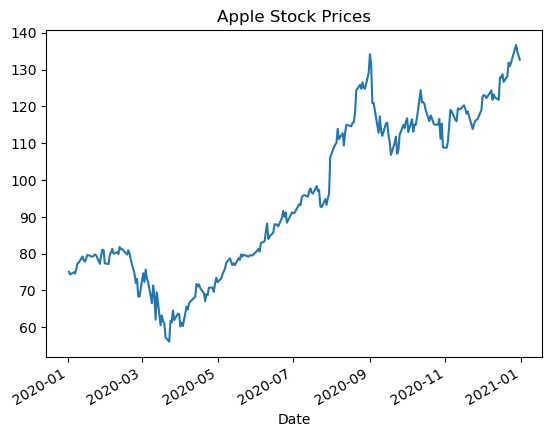

In [7]:
data = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
data['Close'].plot()
plt.title("Apple Stock Prices")
plt.show()
plt.close()

[*********************100%%**********************]  1 of 1 completed


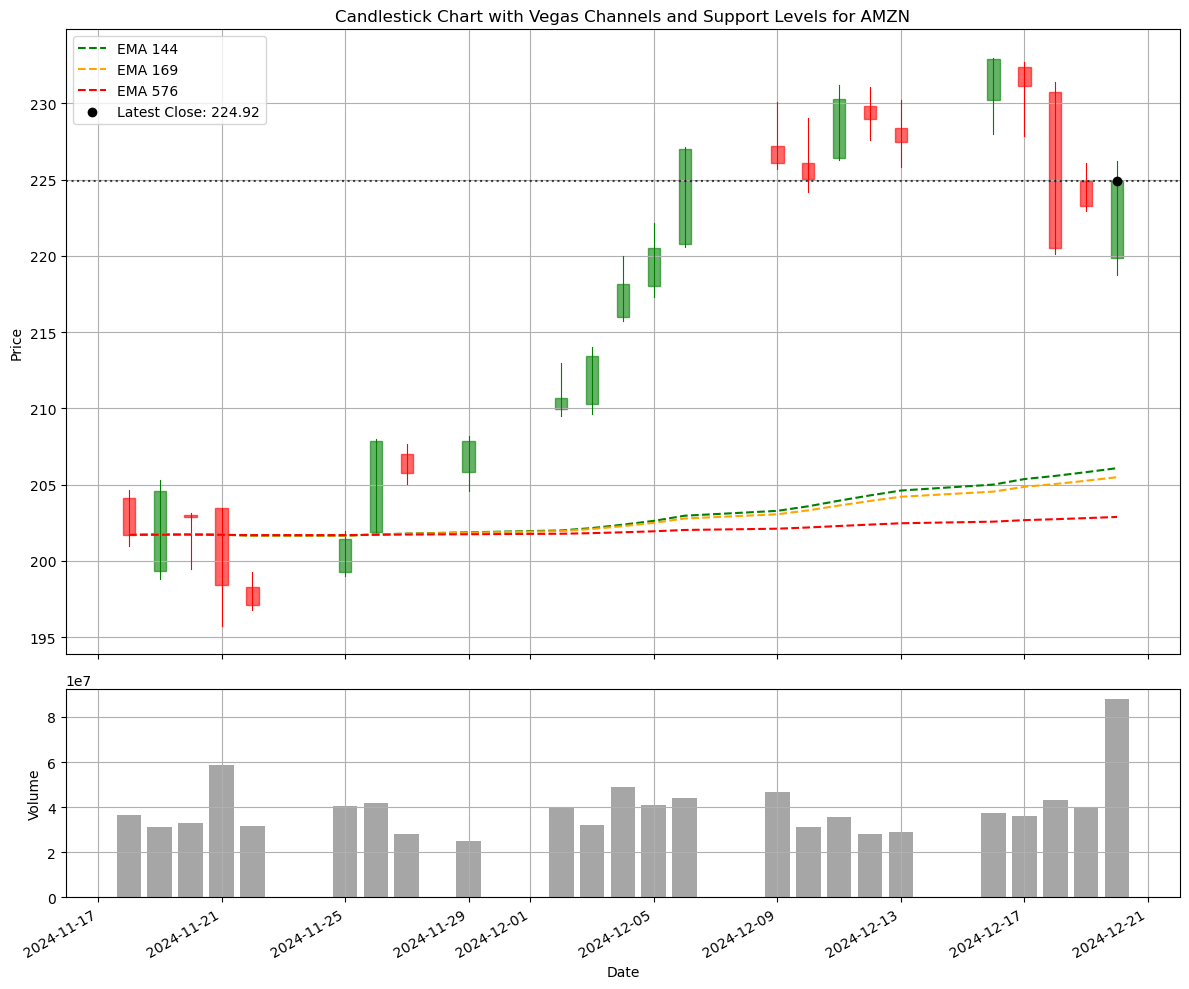

In [17]:
# Stock symbol and date range with Japanese Candles analysis
symbol = 'AMZN'  # Example: Apple stock
# play with days
today = datetime.date.today() # today
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 5
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
# one week from now
#one_week = datetime.timedelta(days=7)
#last_week = today - one_week
#start_date = '2023-01-01'
#start_date = last_week
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)
#stock_data
# Perform Japanese Candle Analysis (calculate EMAs)
stock_data = candle_ema_analysis(stock_data)
#stock_data
# Plot the result
plot_candlestick_with_vegas_and_support(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


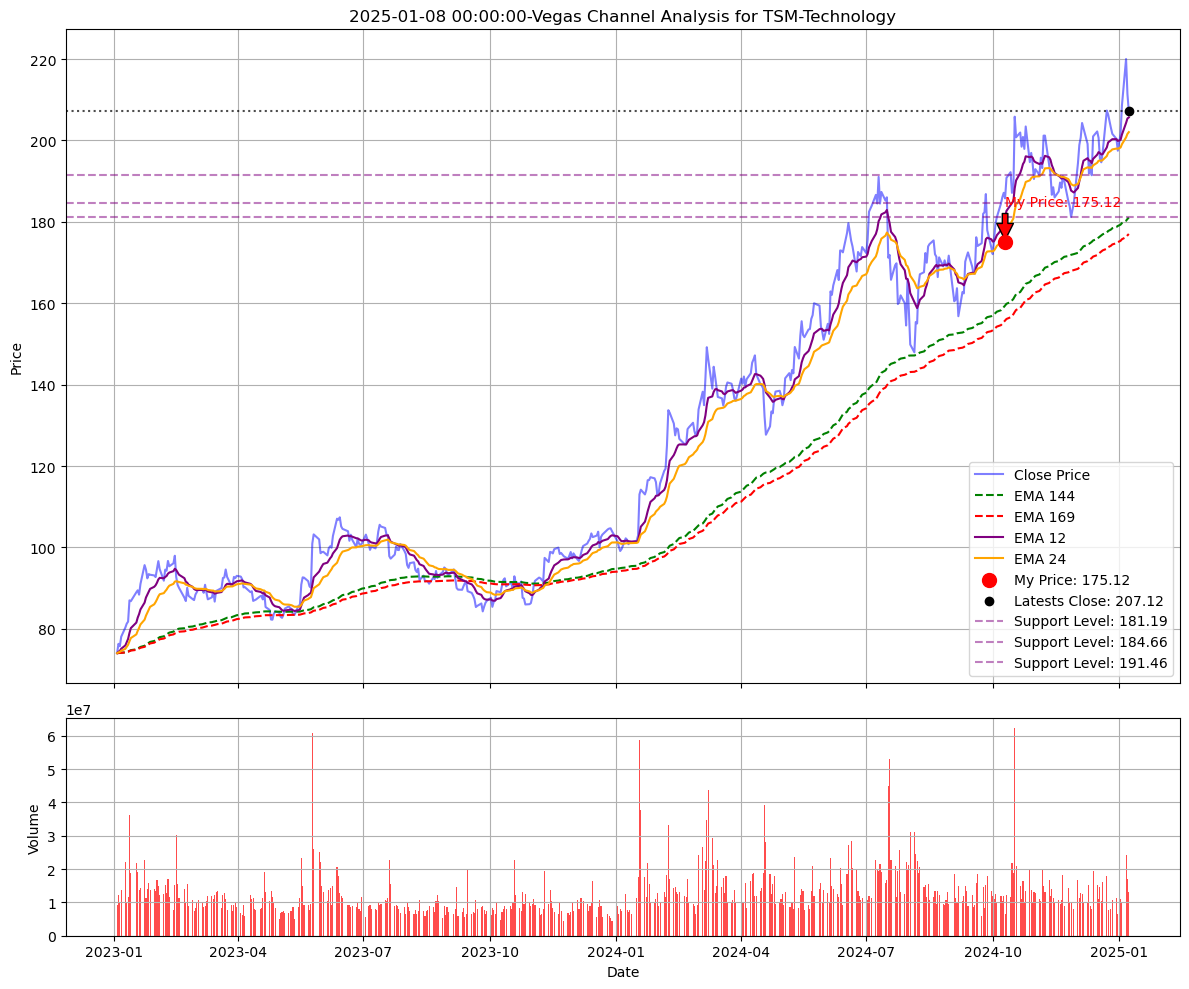

In [51]:
# Stock symbol and date range with Vegas Channel analysis
symbol = 'TSM'  # Example: Apple stock
now_date = date.today()
start_date = '2023-01-01'
#end_date = '2023-10-10'
end_date = now_date

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol, '2024-10-10', 175.12)
plt.close()

[*********************100%%**********************]  1 of 1 completed


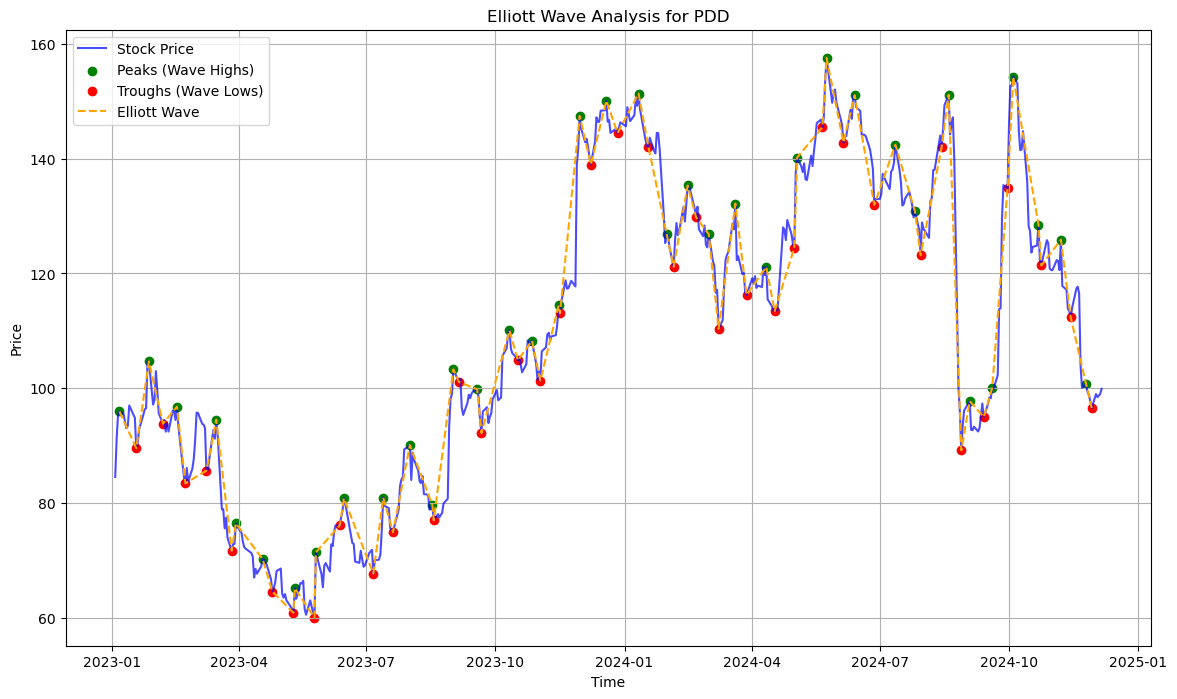

In [62]:
# Stock symbol and date range with Elliot Wave analysis
symbol = 'PDD'  # Example: Apple stock
now_date = date.today()
start_date = '2023-01-01'
#end_date = '2023-10-10'
end_date = now_date

# Step 1: Download the stock data
elliot_stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Step 2: Identify peaks and troughs
elliot_close_prices = elliot_stock_data['Close']
# test
#elliot_close_prices.plot()

distance = 10
peaks, troughs = identify_peaks_and_troughs(elliot_close_prices, distance=distance)

# Step 3: Plot the Elliott wave analysis
plot_elliott_wave(elliot_close_prices, peaks, troughs, title=f"Elliott Wave Analysis for {symbol}")
plt.close()

### Test correlation

[*********************100%%**********************]  2 of 2 completed


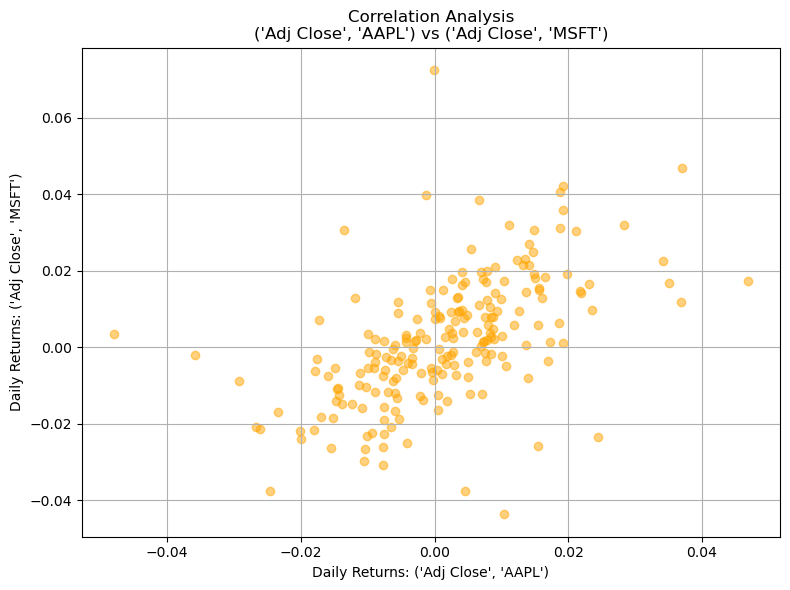

Correlation between AAPL and MSFT: 0.54


In [39]:
# test for corrlation of stocks
ticker1 = "AAPL"  # Apple
ticker2 = "MSFT"  # Microsoft
start_date = "2023-01-01"
end_date = "2023-11-01"

correlation_analysis(ticker1, ticker2, start_date, end_date)

[*********************100%%**********************]  2 of 2 completed


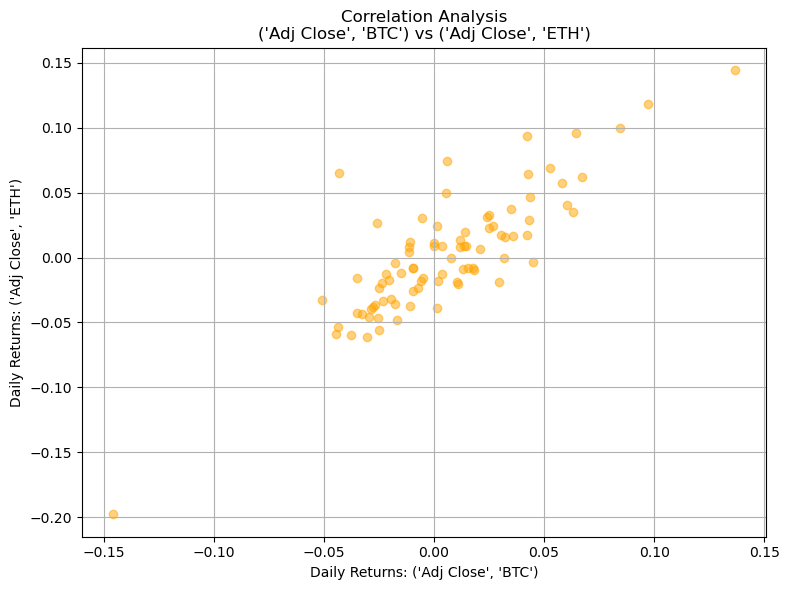

Correlation between BTC and ETH: 0.84


In [44]:
# test for corrlation of stocks
ticker1 = "BTC"  # Apple
ticker2 = "ETH"  # Microsoft
start_date = "2024-01-01"
end_date = "2024-12-01"

correlation_analysis(ticker1, ticker2, start_date, end_date)

[*********************100%%**********************]  2 of 2 completed


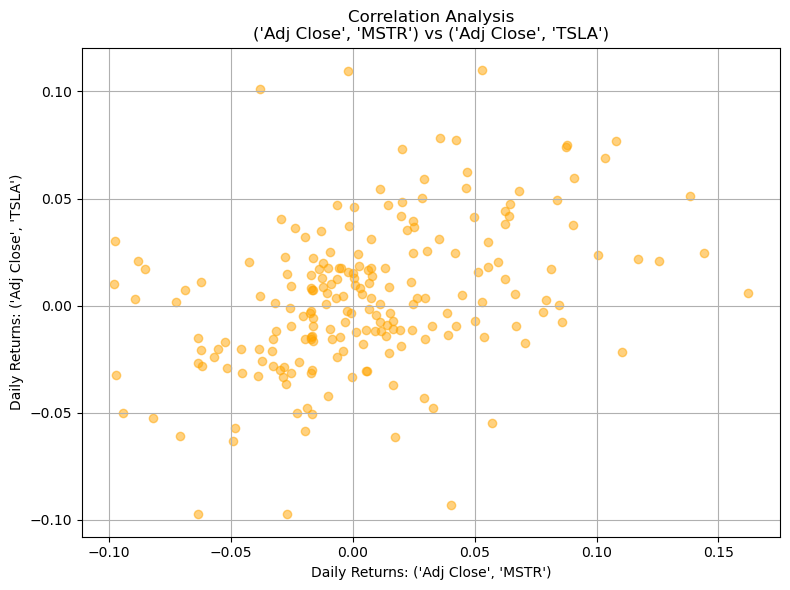

Correlation between TSLA and MSTR: 0.39


In [40]:
# test for corrlation of stocks
ticker1 = "TSLA"  # Apple
ticker2 = "MSTR"  # Microsoft
start_date = "2023-01-01"
end_date = "2023-11-01"

correlation_analysis(ticker1, ticker2, start_date, end_date)